In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.special import softmax
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# from data_gen import init_theta_true_mog_clear, gen_data_mog, comp_true_obj_kkt, f_obj_cubic, task_loss_no_mean
from cvxpy_toy_kkt import cvxpy_toy_parallel_kkt, task_loss_no_mean
from data_gen import generate_data, comp_true_obj, sample_y_from_env

import torch
from diffusion_opt import Diffsion
import model_classes

import warnings
warnings.filterwarnings("ignore")

In [2]:
x_dim = 20
y_dim = 1
batch_size = 256
seed = 1
data_size = 1000
C = 2.0
mc_samples = 20
DEVICE = torch.device("cuda:7")

X, Y, data_info = generate_data(n=data_size, x_dim=x_dim, seed=seed, C=C)
n_tt = int(len(X) * 0.8)
X_train, Y_train = X[:n_tt], Y[:n_tt]
X_test, Y_test = X[n_tt:], Y[n_tt:]
X_train_ = torch.tensor(X_train, dtype=torch.float, device=DEVICE)
Y_train_ = torch.tensor(Y_train, dtype=torch.float, device=DEVICE).unsqueeze(1)
X_test_ = torch.tensor(X_test, dtype=torch.float, device=DEVICE)
Y_test_ = torch.tensor(Y_test, dtype=torch.float, device=DEVICE).unsqueeze(1)
variables_rmse = {'X_train_': X_train_, 'Y_train_': Y_train_, 
            'X_test_': X_test_, 'Y_test_': Y_test_}

th_frac = 0.8
inds = np.random.permutation(X_train.shape[0])
train_inds = inds[ :int(X_train.shape[0] * th_frac)]
hold_inds = inds[int(X_train.shape[0] * th_frac):]
X_train2, X_hold2 = X_train[train_inds], X_train[hold_inds]
Y_train2, Y_hold2 = Y_train[train_inds], Y_train[hold_inds]
X_train2_ = torch.tensor(X_train2, dtype=torch.float32, device=DEVICE)
Y_train2_ = torch.tensor(Y_train2, dtype=torch.float32, device=DEVICE).unsqueeze(1)
X_hold2_ = torch.tensor(X_hold2, dtype=torch.float32, device=DEVICE)
Y_hold2_ = torch.tensor(Y_hold2, dtype=torch.float32, device=DEVICE).unsqueeze(1)
variables_task = {'X_train_': X_train2_, 'Y_train_': Y_train2_, 
        'X_hold_': X_hold2_, 'Y_hold_': Y_hold2_,
        'X_test_': X_test_, 'Y_test_': Y_test_}

params = {'n': y_dim, 'mc_samples': mc_samples, "data_info": data_info, 'C': C}
    
f_evals_regret, f_evals_env, z_star_evals_regret, z_star_evals_env = comp_true_obj(X_test_, Y_test_, params, seed=seed, device=DEVICE, simple=False)
print(f_evals_regret)

F'(0)= -0.31110987067222595    F'(1)= 0.3660118281841278
tensor(0.9039, device='cuda:7')


In [ ]:
YOUR_HOME_FOLDER = ""
stochastic_save_path = f"{YOUR_HOME_FOLDER}/e2e-model-learning/synthetic_example_new/synthetic_results_{data_size}_{y_dim}_pretrain/0/diffusion_point_est_{data_size}.pth"

diffusion_timesteps = 1000
diffusion = Diffsion(x_dim=x_dim, y_dim=y_dim, timesteps=diffusion_timesteps, device=DEVICE)
diffusion.model_net.load_state_dict(torch.load(stochastic_save_path, map_location=DEVICE))

deterministic_save_path = f"{YOUR_HOME_FOLDER}/e2e-model-learning/synthetic_example_new/synthetic_results_{data_size}_0.3_pretrain/0/task_net_deterministic_mlp_{data_size}.pth"

mlp_model = model_classes.MLP(X_train2_.shape[1], 1024, Y_train2_.shape[1])
mlp_model.load_state_dict(torch.load(deterministic_save_path, map_location=DEVICE))
mlp_model.to(DEVICE)
mlp_model.eval()

gaussian_save_path = f"{YOUR_HOME_FOLDER}/e2e-model-learning/synthetic_example_new/synthetic_results_{data_size}_0.3_pretrain/0/task_net_mlp_gaussian_distr_{data_size}.pth"

gaussian_model = model_classes.GaussianMLP(X_train2_.shape[1], [1024, 1024], Y_train2_.shape[1])
gaussian_model.load_state_dict(torch.load(gaussian_save_path, map_location=DEVICE))
gaussian_model.to(DEVICE)
gaussian_model.eval()

GaussianMLP(
  (feature): Sequential(
    (0): Linear(in_features=20, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
  )
  (mu_head): Linear(in_features=1024, out_features=1, bias=True)
  (logvar_head): Linear(in_features=1024, out_features=1, bias=True)
)

In [4]:
layer_sto = cvxpy_toy_parallel_kkt(params, mc_samples=mc_samples * X_test_.shape[0])
layer_det = cvxpy_toy_parallel_kkt(params, mc_samples=X_test_.shape[0])
with torch.no_grad():
    # Diffusion prediction
    y_pred_sto = diffusion.sample_elbo(X_test_.repeat(mc_samples, 1), test_mode=True)
    y_pred_sto = y_pred_sto.view(mc_samples, -1, y_dim).permute(1, 0, 2).contiguous()
    z_star_sto, _ = layer_sto(y_pred_sto.reshape(1, -1, 1))
    z_star_sto = z_star_sto[0].flatten()

    # Gaussian model prediction
    mu_pred, logvar_pred = gaussian_model(X_test_.repeat(mc_samples, 1))
    sig_pred = torch.exp(0.5 * logvar_pred)
    y_pred_gaussian = mu_pred + torch.randn_like(sig_pred) * sig_pred
    y_pred_gaussian = y_pred_gaussian.view(mc_samples, -1, y_dim).permute(1, 0, 2).contiguous()
    z_star_gaussian, _ = layer_sto(y_pred_gaussian.reshape(1, -1, 1))
    z_star_gaussian = z_star_gaussian[0].flatten()

    # Deterministic model prediction
    y_pred_det = mlp_model(X_test_)
    z_star_det, _ = layer_det(y_pred_det.unsqueeze(0))
    z_star_det = z_star_det[0].flatten()

cost_true = task_loss_no_mean(z_star_evals_regret, Y_test_, params).flatten()
# Y_eval_flat = Y_eval.flatten()
z_star_true  = z_star_evals_regret.flatten()
N = len(z_star_true)

df = pd.DataFrame({
    "z_true":      z_star_true.cpu().numpy(),
    "Sto":         z_star_sto.cpu().numpy(),
    "Det":         z_star_det.cpu().numpy(),
    "Gaussian":    z_star_gaussian.cpu().numpy(),
    "cost_true": cost_true.cpu().numpy(),
})

df_res = df.melt(
    id_vars=["z_true", "cost_true"], 
    var_name="method", value_name="z_hat"
)

df_res["error"] = df_res["z_hat"] - df_res["z_true"]

df_res["cost_hat"]  = np.nan

for m, z_vec in {"Sto": z_star_sto, "Det": z_star_det, "Gaussian": z_star_gaussian}.items():
    mask = df_res["method"] == m
    # df_res.loc[mask, "cost_hat"] = f_obj_cubic(z_vec.cpu().numpy(), Y_eval_flat.cpu().numpy(), params).item()
    cost_hat_all = task_loss_no_mean(z_vec, Y_test_, params).flatten()  # shape: (N,)
    df_res.loc[mask, "cost_hat"] = cost_hat_all.cpu().numpy()

df_res["regret"] = df_res["cost_hat"] - df_res["cost_true"]
# save df_res
df_res.to_csv("df_res.csv", index=False)

In [5]:
def plot_all_models(df_res):
    # assert y_dim == 1 or len(Y_eval.shape) == 2, "Only 1D z* supported currently"

    df_res = df_res

    fig, axs = plt.subplots(2, 2, figsize=(12, 9))

    # Parity plot
    ax = axs[0, 0]
    sns.scatterplot(data=df_res, x="z_true", y="z_hat", hue="method", alpha=0.5, s=28, ax=ax)
    mn = min(df_res["z_true"].min(), df_res["z_hat"].min())
    mx = max(df_res["z_true"].max(), df_res["z_hat"].max())
    ax.plot([mn, mx], [mn, mx], 'k--', lw=1)
    ax.set_xlabel("True $z^*$")
    ax.set_ylabel("Predicted $\\hat z$")
    ax.set_title("Parity Plot")

    # Error distribution
    ax = axs[0, 1]
    sns.histplot(data=df_res, x="error", hue="method",
                 kde=True, stat="density", common_norm=False,
                 alpha=0.35, bins=40, ax=ax)
    ax.axvline(0, color="k", linestyle="--", lw=1)
    ax.set_xlabel("$\\hat z - z^*$")
    ax.set_ylabel("Density")
    ax.set_title("Error Distribution")

    # Regret distribution
    ax = axs[1, 0]
    sns.histplot(data=df_res, x="regret", hue="method",
                 kde=True, stat="density", common_norm=False,
                 alpha=0.35, bins=40, ax=ax)
    ax.axvline(0, color="k", linestyle="--", lw=1)
    ax.set_xlabel("$f(y,\\hat z) - f(y,z^*)$")
    ax.set_ylabel("Density")
    ax.set_title("Regret Distribution")
    # ax.set_ylim(0, 5)

    # Regret violin
    ax = axs[1, 1]
    sns.violinplot(data=df_res, x="method", y="regret", cut=0, inner="quartile", ax=ax)
    ax.axhline(0, color="k", linestyle="--", lw=1)
    ax.set_ylabel("Regret")
    ax.set_title("Regret by Method")

    plt.tight_layout()
    plt.show()

    return df_res, y_pred_sto, z_star_true, z_star_sto, z_star_det


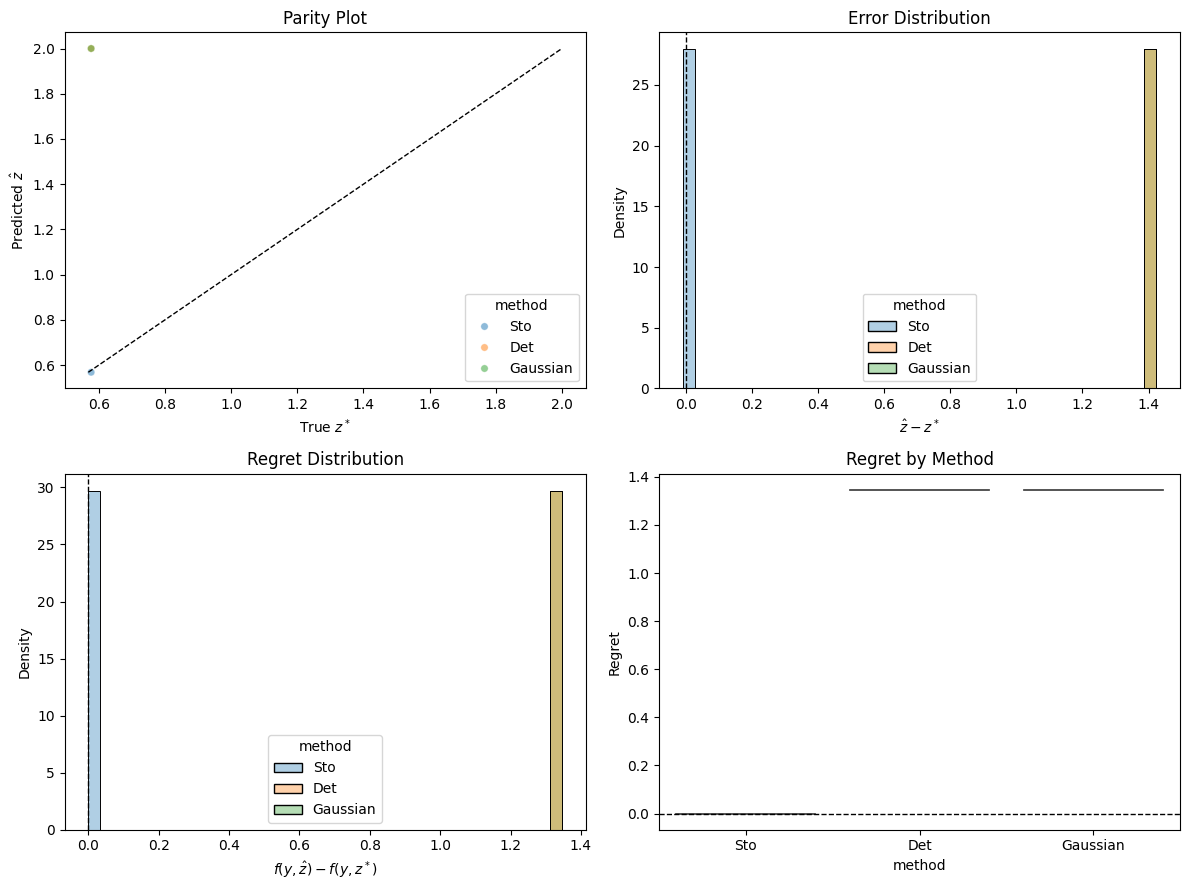

(     z_true  cost_true    method     z_hat     error  cost_hat    regret
 0  0.576665   0.903898       Sto  0.568149 -0.008516  0.903923  0.000024
 1  0.576665   0.903898       Det  2.000000  1.423335  2.249846  1.345948
 2  0.576665   0.903898  Gaussian  2.000000  1.423335  2.249846  1.345948,
 tensor([[[ 0.5459],
          [ 0.4833],
          [ 0.5246],
          ...,
          [-1.6303],
          [ 0.4800],
          [ 0.5610]],
 
         [[-1.3867],
          [ 0.5546],
          [ 0.6318],
          ...,
          [ 0.5934],
          [ 0.4711],
          [ 0.5715]],
 
         [[-1.4899],
          [ 0.5010],
          [ 0.6222],
          ...,
          [ 0.4873],
          [ 0.4570],
          [ 0.5224]],
 
         ...,
 
         [[ 0.5816],
          [ 0.4204],
          [ 0.3779],
          ...,
          [ 0.5325],
          [ 0.5084],
          [ 0.4839]],
 
         [[ 0.5925],
          [ 0.6877],
          [ 0.4838],
          ...,
          [ 0.5212],
          [ 

In [6]:
plot_all_models(df_res)

In [7]:
df_res

,z_true,cost_true,method,z_hat,error,cost_hat,regret
0,0.576665,0.903898,Sto,0.568149,-0.008516,0.903923,0.000024
1,0.576665,0.903898,Det,2.000000,1.423335,2.249846,1.345948
2,0.576665,0.903898,Gaussian,2.000000,1.423335,2.249846,1.345948


In [8]:
sample_size = 2000
_X = torch.randn(sample_size, x_dim).to(DEVICE)
_Y = sample_y_from_env(_X, y_dim=y_dim, mc_samples=mc_samples, params=params)
with torch.no_grad():
    y_pred_sto = diffusion.sample_elbo(_X.repeat(mc_samples, 1), test_mode=True)

(<Figure size 4200x1050 with 3 Axes>,
 array([<Axes: title={'center': '(a) Per-sample Decision Cost $f(y,z)$'}, xlabel='$z$', ylabel='Decision Cost'>,
        <Axes: title={'center': '(b) Expected Decision Cost $\\mathbb{E}[f(y, z)]$'}, xlabel='$z$', ylabel='Decision Cost'>,
        <Axes: title={'center': '(c) Predicted vs True Distribution'}, xlabel='y', ylabel='Density'>],
       dtype=object))

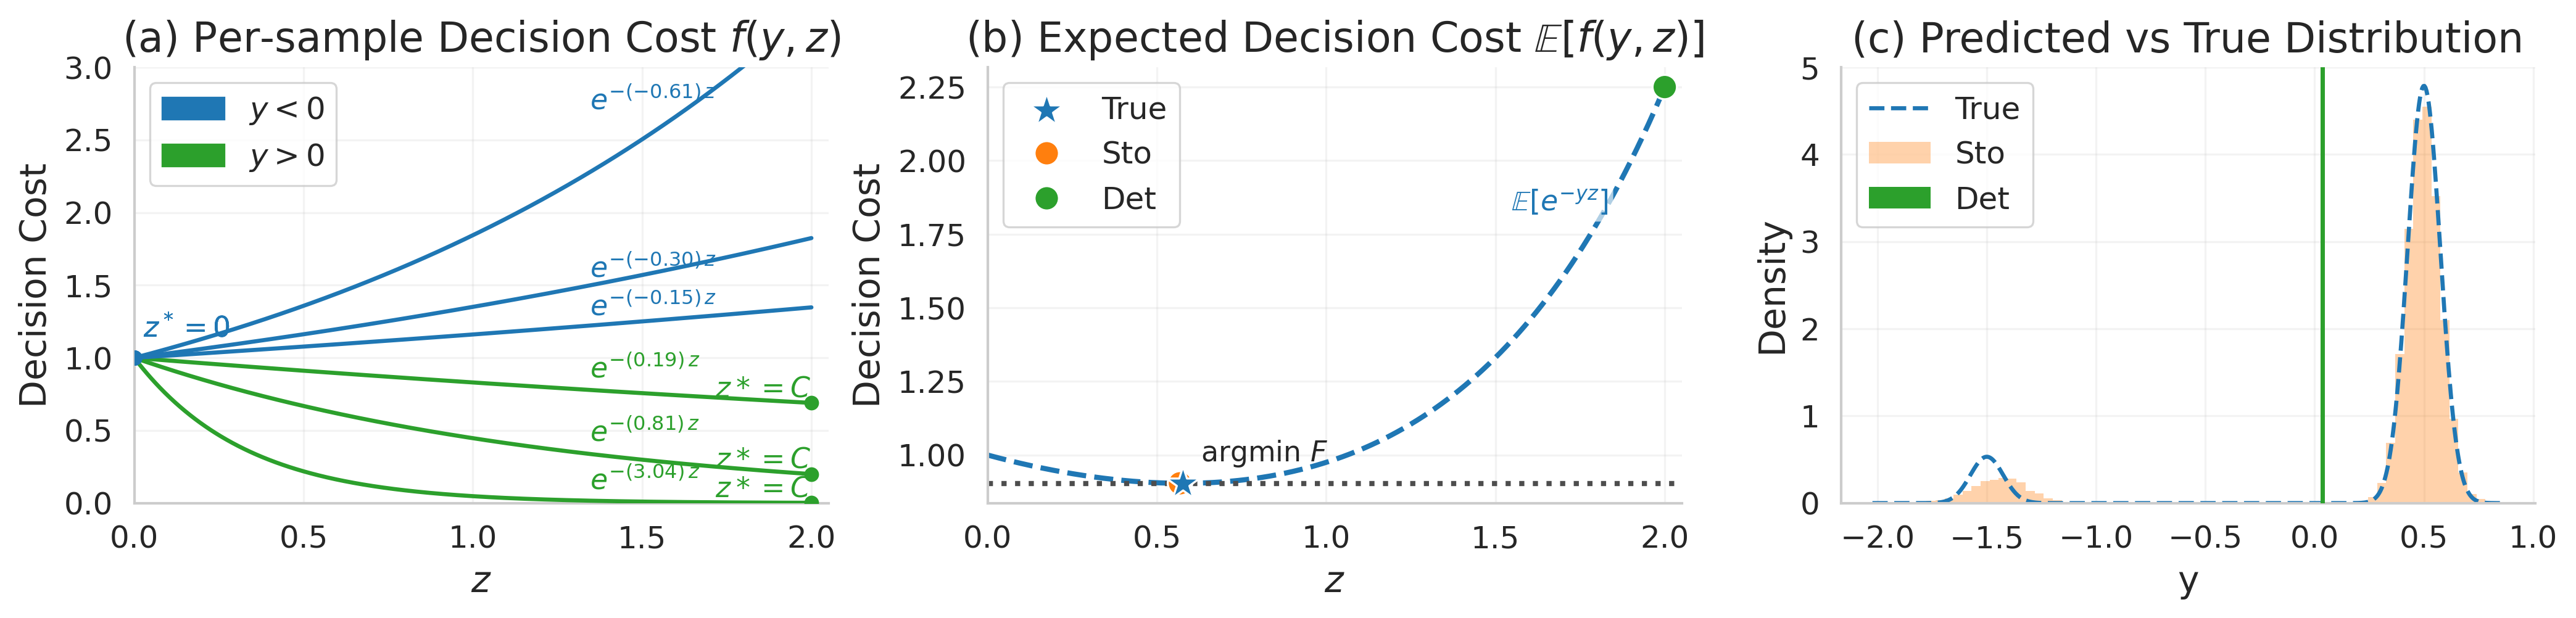

In [12]:
from matplotlib import transforms as mtransforms

COLORS = {
    "F":  "#d62728",
    "True": "#1f77b4",
    "Sto":  "#ff7f0e",
    "Det":  "#2ca02c",
    "Ypos":"#2ca02c",
    "Yneg":"#1f77b4",
}

FS = 12

sns.set_theme(style="whitegrid", context="paper", font_scale=1.25)
plt.rcParams.update({
    "font.size": FS,
    "axes.titlesize": FS + 4,
    "axes.labelsize": FS + 2,
    "xtick.labelsize": FS,
    "ytick.labelsize": FS,
    "legend.fontsize": FS,
    "legend.title_fontsize": FS + 1,
    "figure.titlesize": FS + 5,
    "grid.alpha": 0.23,
    "axes.linewidth": 1.0,
})

def plot_motivating(
    Y, z_true, z_sto, z_det, C,
    Y_true, Y_pred_sto, Y_pred_det, df_res, FS,
    names=None, bins=100, idx=None,
    Y_tests=None, labels=None, y_det=None, grid_points=801,
    data_info=None,
    eps=1e-12
):
    fig, axes = plt.subplots(1, 3, figsize=(14, 3.5), dpi=300)
    ax0, ax1, ax2 = axes


    Y_torch = torch.as_tensor(Y, dtype=torch.float64).detach().flatten()
    device = Y_torch.device
    zs = torch.linspace(0.0, float(C), grid_points, dtype=torch.float64, device=device)

    def F_curve_from(Y_like):
        Yk_t = torch.as_tensor(Y_like, dtype=torch.float64).flatten().to(device)
        return torch.exp(-Yk_t[:, None] * zs[None, :]).mean(dim=0)  # (G,)

    def F_at_scalar(zf):
        z_t = torch.tensor(float(zf), dtype=torch.float64, device=device)
        return float(torch.exp(-Y_torch * z_t).mean().item())

    def grad_at_scalar(zf):
        z_t = torch.tensor(float(zf), dtype=torch.float64, device=device)
        return float(-(Y_torch * torch.exp(-Y_torch * z_t)).mean().item())

    def argmin_bisection(C_float: float, iters: int = 80) -> float:
        lo, hi = 0.0, C_float
        if grad_at_scalar(0.0) >= 0:
            return 0.0
        if grad_at_scalar(C_float) <= 0:
            return C_float
        for _ in range(iters):
            mid = 0.5 * (lo + hi)
            if grad_at_scalar(mid) > 0:
                hi = mid
            else:
                lo = mid
        return 0.5 * (lo + hi)

    if Y_tests is None:
        Y_tests = []
    if labels is None:
        labels = [f"set {k+1}" for k in range(len(Y_tests))]

    import matplotlib.patches as mpatches

    x = zs.cpu().numpy()
    F_list = [F_curve_from(Yk).cpu().numpy() for Yk in Y_tests]

    pos_color = COLORS["Ypos"]  # y>0
    neg_color = COLORS["Yneg"]  # y<0
    for k, Yk in enumerate(Y_tests):
        yhat = float(np.mean(np.asarray(Yk)))
        color = pos_color if yhat > 0 else neg_color

        curve = np.exp(-yhat * x)
        ax0.plot(x, curve, lw=1.6, color=color, zorder=3)
        z_lab = 0.65 * float(C)

        if yhat < -eps:
            ax0.scatter([0.0], [np.exp(-yhat*0.0)], s=26, color=color, zorder=4)
            ax0.text(0.0, np.exp(-yhat*0.0)+0.1, r" $z^*=0$", va="bottom", ha="left",
                    fontsize=FS-1, color=color)
            if yhat < -0.4:
                y_lab = float(np.exp(-yhat * z_lab)) + 0.5
                ax0.annotate(rf"$e^{{-({yhat:.2f})\,z}}$",
                            xy=(z_lab, y_lab), xytext=(6, 0), textcoords="offset points",
                            fontsize=FS-1, color=color,
                            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0))
            else:
                y_lab = float(np.exp(-yhat * z_lab)) + 0.08
                ax0.annotate(rf"$e^{{-({yhat:.2f})\,z}}$",
                            xy=(z_lab, y_lab), xytext=(6, 0), textcoords="offset points",
                            fontsize=FS-1, color=color,
                            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0))
        else:
            ax0.scatter([float(C)], [np.exp(-yhat*float(C))], s=24, color=color, zorder=4)
            ax0.text(float(C), np.exp(-yhat*float(C)), r" $z*=C$", va="bottom", ha="right",
                    fontsize=FS-1, color=color)
                    
            y_lab = float(np.exp(-yhat * z_lab)) + 0.08
            ax0.annotate(rf"$e^{{-({yhat:.2f})\,z}}$",
                        xy=(z_lab, y_lab), xytext=(6, 0), textcoords="offset points",
                        fontsize=FS-1, color=color,
                        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.01))


    handles = [
        mpatches.Patch(color=neg_color, label=r"$y<0$"),
        mpatches.Patch(color=pos_color, label=r"$y>0$"),
        # mpatches.Patch(color="k", label="True $F(z)$")
    ]
    ax0.legend(handles=handles, frameon=True)

    ax0.set_xlim(0, float(C) + 0.05)
    ax0.set_ylim(0, 3)
    ax0.set_xlabel(r"$z$")
    ax0.set_ylabel("Decision Cost")
    ax0.set_title(r"(a) Per-sample Decision Cost $f(y,z)$")
    sns.despine(ax=ax0)


    F_vals = F_curve_from(Y_torch)

    def _to_scalar(z):
        if not isinstance(z, torch.Tensor):
            return float(z)
        z = z.detach().flatten()
        if z.numel() == 1:
            return float(z.item())
        i = 0 if idx is None else int(idx)
        return float(z[i].item())

    zT = _to_scalar(z_true)
    zS = _to_scalar(z_sto)
    zD = _to_scalar(z_det)

    FT, FS, FD = F_at_scalar(zT), F_at_scalar(zS), F_at_scalar(zD)

    df_curve = pd.DataFrame({"z": zs.cpu().numpy(), "F": F_vals.cpu().numpy()})
    df_pts = pd.DataFrame({
        "which": ["Sto", "Det", ],
        "z":     [zS,    zD,    ],
        "F":     [FS,    FD,    ]
    })

    # sns.lineplot(
    #     data=df_curve, x="z", y="F", ax=ax1,
    #     lw=2, ls="--", color="#d62728",
    #     label=r"$\mathbb{E}[f(y,z)]$"
    # )
    # ax1.fill_between(df_curve["z"], df_curve["F"].min(), df_curve["F"], alpha=0.12, color="#d62728")
    ax1.plot(df_curve["z"].to_numpy(),
         df_curve["F"].to_numpy(),
         color=COLORS["True"], lw=2, ls="--",
         # label=r"$\mathbb{E}[f(y,z)]$"
         )

    z_lab1 = 1 * float(C) - 0.5
    y_lab1 = F_at_scalar(z_lab1) + 0.5
    ax1.annotate(
        r"$\mathbb{E}[e^{-yz}]$",
        xy=(z_lab1, y_lab1), xytext=(6, 0), textcoords="offset points",
        fontsize=11, color=COLORS["True"],
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.65)
    )

    sns.scatterplot(
        data=df_pts, x="z", y="F", hue="which", ax=ax1, s=90,
        palette={"Sto": COLORS["Sto"], "Det": COLORS["Det"], "True": COLORS["True"]},
        edgecolor="white", linewidth=0.8, zorder=5
    )

    z_star = argmin_bisection(float(C))
    F_star = F_at_scalar(z_star)
    # ax1.axvline(z_star, color="0.3", ls=":", lw=1)
    ax1.text(z_star, df_curve["F"].min() + 0.05, "  argmin $F$", va="bottom", ha="left", fontsize=11)
    ax1.axhline(F_star, color="0.3", ls=":", lw=2)
    ax1.scatter([z_star], [F_star], s=180, marker="*", color=COLORS["True"],
                edgecolors="white", linewidth=0.8, zorder=6, label=r"True")

    ax1.set(xlim=(0, float(C) + 0.05), xlabel=r"$z$", ylabel="Decision Cost", title=r"(b) Expected Decision Cost $\mathbb{E}[f(y, z)]$")
    desired_order = ["True", "Sto", "Det"]

    handles, labels = ax1.get_legend_handles_labels()
    by_label = {lab: h for h, lab in zip(handles, labels)}
    ordered = [by_label[l] for l in desired_order if l in by_label]

    ax1.legend(ordered, [l for l in desired_order if l in by_label],
            frameon=True, loc="upper left")
    sns.move_legend(ax1, "upper left", frameon=True)

    sns.despine(ax=ax1)

    def _to_numpy_2d(arr):
        if isinstance(arr, torch.Tensor):
            arr = arr.detach().cpu().numpy()
        arr = np.asarray(arr)
        if arr.ndim == 1:
            arr = arr.reshape(-1, 1)
        elif arr.ndim == 3:
            B, M, d = arr.shape
            arr = arr.reshape(B * M, d)
        elif arr.ndim != 2:
            raise ValueError(f"Expected 1D, 2D, or 3D input; got shape {arr.shape}")
        return arr

    Y_true_np = _to_numpy_2d(Y_true)
    Y_pred_sto_np = _to_numpy_2d(Y_pred_sto)
    Y_pred_det_np = _to_numpy_2d(Y_pred_det)

    d = Y_true_np.shape[1]
    if names is None:
        names = [f"y{j+1}" for j in range(d)]
    j = 0


    if data_info is not None:
        p_pos   = float(data_info["p_pos"])
        a_pos   = float(data_info["a_pos"])
        b_neg   = float(data_info["b_neg"])
        sigma   = float(data_info["sigma"])
        y_scale = float(data_info.get("y_scale", 1.0))
        y_shift = float(data_info.get("y_shift", 0.0))

        def _normal_pdf(x, mu, sig):
            return (1.0 / (np.sqrt(2*np.pi) * sig)) * np.exp(-0.5 * ((x - mu) / sig) ** 2)

        mu_pos = y_scale * a_pos    + y_shift
        mu_neg = y_scale * (-b_neg) + y_shift
        sig    = max(1e-12, y_scale * sigma)

        x_min = float(min(Y_pred_sto_np[:, j].min(), Y_pred_det_np[:, j].min(), mu_neg - 4*sig))
        x_max = float(max(Y_pred_sto_np[:, j].max(), Y_pred_det_np[:, j].max(), mu_pos + 4*sig))
        x_grid = np.linspace(x_min, x_max, 600)

        pdf_true = p_pos * _normal_pdf(x_grid, mu_pos, sig) \
                 + (1.0 - p_pos) * _normal_pdf(x_grid, mu_neg, sig)

        ax2.plot(x_grid, pdf_true, ls="--", lw=1.6, label="True", color=COLORS["True"])

    ax2.hist(
        Y_pred_sto_np[:, j], bins=bins, density=True, alpha=0.35,
        color=COLORS["Sto"], edgecolor="none", label="Sto"
    )
    # ax2.hist(
    #     Y_pred_det_np[:, j], bins=bins, density=True, alpha=0.35,
    #     color=colors["Det"], edgecolor="none", label="Det"
    # )
    ax2.hist(
        Y_pred_det_np[:, j], bins=50, density=True,
        # histtype="step",
        color=COLORS["Det"],
        edgecolor= "none",
        linewidth=1000,
        linestyle="--",
        label="Det",
        zorder=6
    )

    ax2.set_title("(c) Predicted vs True Distribution")
    ax2.set_xlabel(names[j])
    ax2.set_ylabel("Density")
    ax2.legend(frameon=True)
    ax2.set_ylim(0, 5)
    # ax2.set_xlim(-3, x_max)

    sns.despine(ax=ax2)

    fig.tight_layout()
    fig.savefig("motivating_plot.pdf", dpi=1000)
    return fig, axes

Y0 = np.random.normal(3.0, 0.7, size=800)
Y1 = np.random.normal(0.8, 0.7, size=800)
Y2 = np.random.normal(0.2, 0.8, size=800)
Y3 = np.random.normal( -0.6, 0.8, size=800)
Y4 = np.random.normal( -0.3, 0.8, size=800)
Y5 = np.random.normal( -0.1, 0.8, size=800)


Y_tests = [Y0, Y1, Y2, Y3, Y4, Y5]

plot_motivating(
    Y_test_, z_star_true, z_star_sto, z_star_det, C,
    _Y.flatten(), y_pred_sto.flatten(), y_pred_det.flatten(), df_res, data_info=data_info, FS=FS,
    names=["y"], Y_tests=Y_tests, bins=70
)


In [10]:
def plot_upper_F_multi(Y_tests, C, y_det=None, labels=None, grid_points=801, eps=1e-12):
    if not isinstance(Y_tests, (list, tuple)):
        Y_tests = [Y_tests]
    K = len(Y_tests)
    if labels is None:
        labels = [f"set {k+1}" for k in range(K)]

    if y_det is None:
        y_det = []
        for Y in Y_tests:
            y_det.append(float(np.asarray(Y).mean()))
    else:
        y_det = list(y_det)

    sns.set_theme(style="whitegrid", context="paper", font_scale=1.05)
    fig, ax = plt.subplots(1, 1, figsize=(6.6, 4.0), dpi=300)

    zs = torch.linspace(0.0, float(C), grid_points, dtype=torch.float64)

    palette = sns.color_palette(n_colors=K)
    for k, (Yk, yhat) in enumerate(zip(Y_tests, y_det)):
        Yk_t = torch.as_tensor(Yk, dtype=torch.float64).flatten()
        F_vals = torch.exp(-Yk_t[:, None] * zs[None, :]).mean(dim=0)  # (G,)

        ax.plot(zs.cpu().numpy(), F_vals.cpu().numpy(),
                label=f"{labels[k]} (ŷ={yhat:.3g})",
                lw=2, alpha=0.95, color=palette[k])

        if yhat > eps:
            z_det_star = float(C)
        elif yhat < -eps:
            z_det_star = 0.0
        else:
            z_det_star = None

        if z_det_star is not None:
            ax.axvline(z_det_star, ls=":", lw=1.5, color=palette[k], alpha=0.9)

    ax.set_xlim(0, C)
    ax.set_xlabel(r"$z$")
    ax.set_ylabel(r"$F(z)=\mathbb{E}[\exp(-Y z)]$")
    ax.set_title("Upper-level F(z) for multiple $y_{test}$ sets\n(with deterministic $z^*_{det}$)")
    ax.legend(frameon=True)
    sns.despine()
    fig.tight_layout()
    return fig, ax

(<Figure size 1980x1200 with 1 Axes>,
 <Axes: title={'center': 'Upper-level F(z) for multiple $y_{test}$ sets\n(with deterministic $z^*_{det}$)'}, xlabel='$z$', ylabel='$F(z)=\\mathbb{E}[\\exp(-Y z)]$'>)

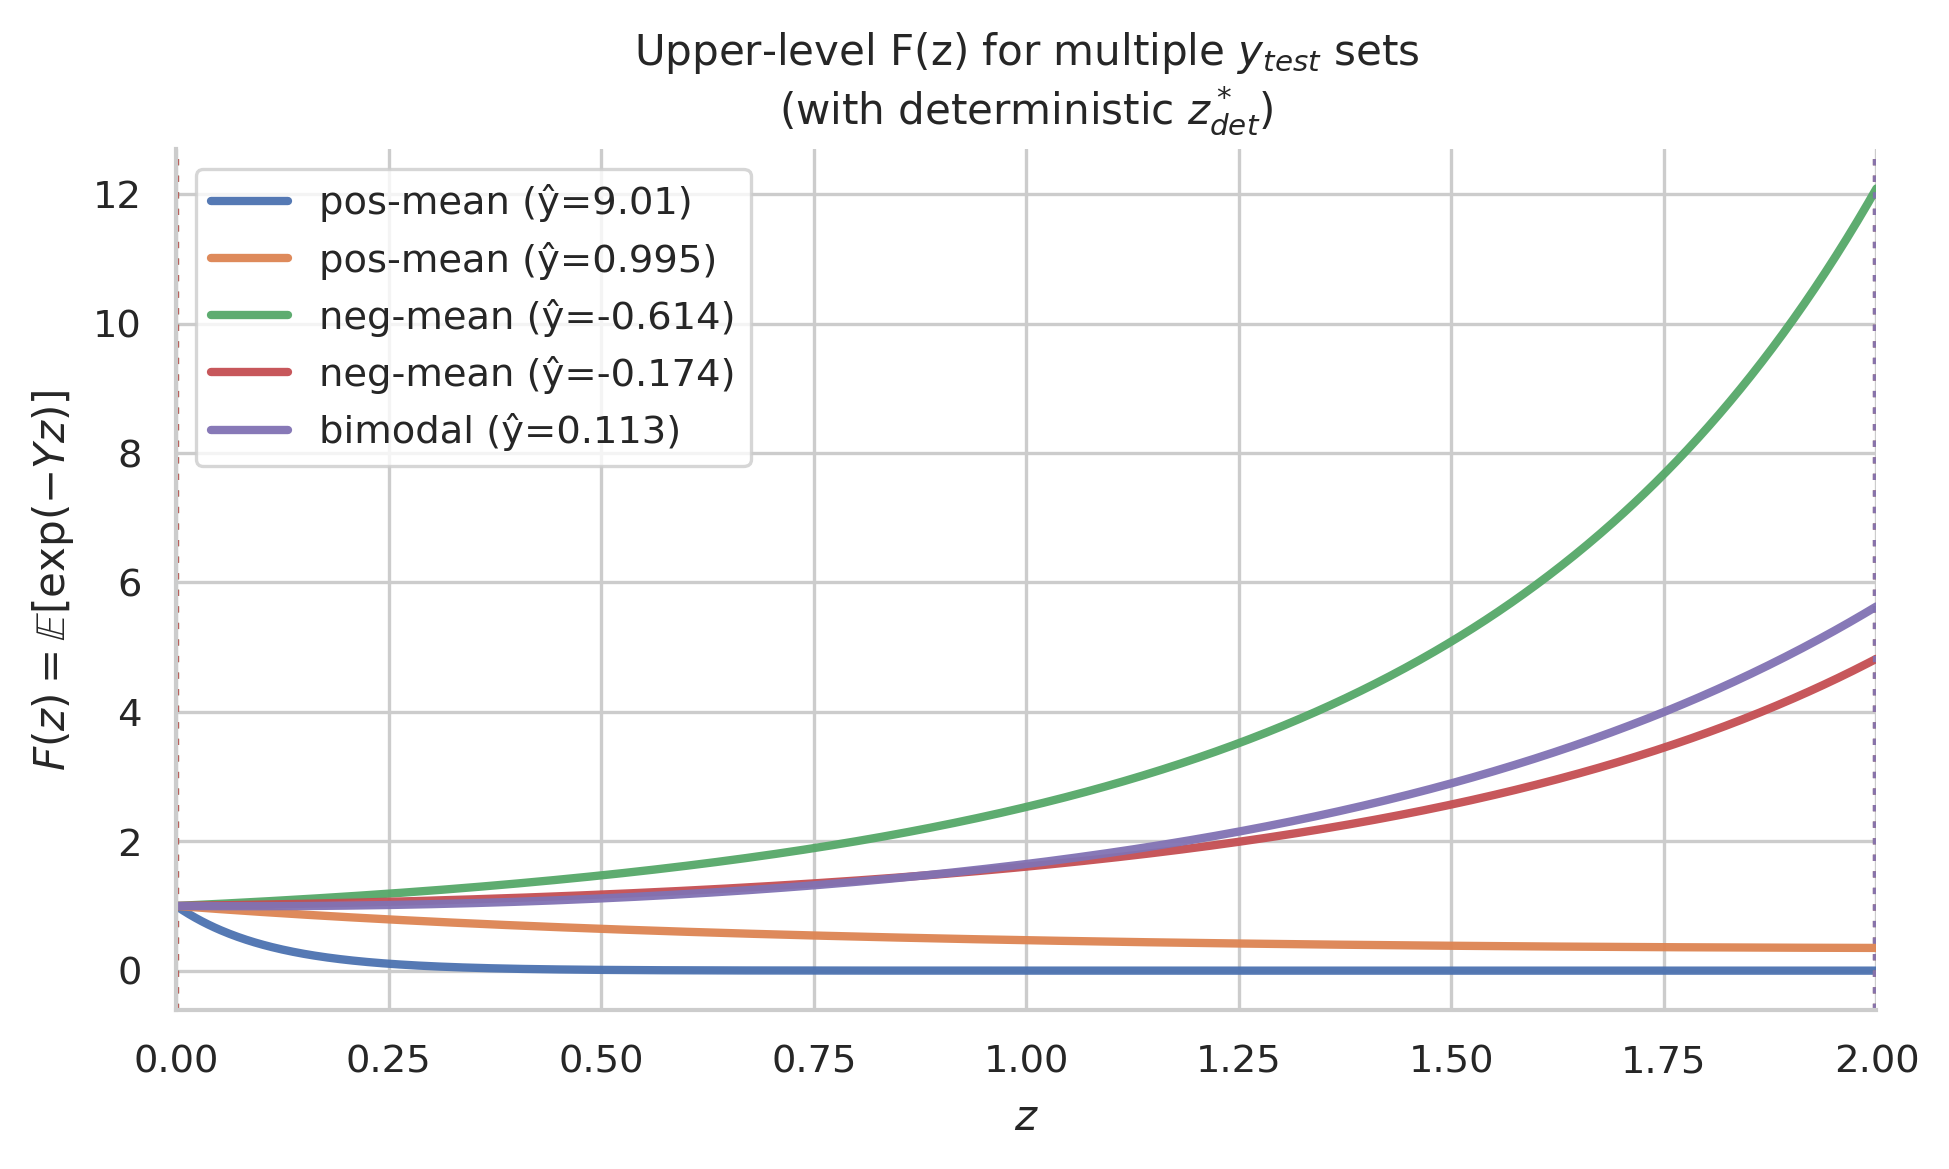

In [40]:
Y0 = np.random.normal(9.0, 0.7, size=800)
Y1 = np.random.normal(1.0, 0.7, size=800)
Y2 = np.random.normal( -0.6, 0.8, size=800)
Y3 = np.random.normal( -0.2, 0.8, size=800)
Y4 = np.concatenate([np.random.normal(1.2,0.4,400), np.random.normal(-1.0,0.5,400)])
plot_upper_F_multi([Y0, Y1, Y2, Y3, Y4], C=2.0, labels=["pos-mean", "pos-mean","neg-mean","neg-mean","bimodal"])

# Y1 = np.random.normal(1.0, 1, size=800)
# Y2 = np.random.normal(-3.0, 1.0, size=800)
# Y3 = np.concatenate([np.random.normal(1.2,0.4,400), np.random.normal(-1.0,0.5,400)])
# plot_upper_F_multi([Y1, Y2, Y3], C=2.0, labels=["pos-mean","neg-mean","bimodal"])

***Backup***

In [ ]:
from matplotlib import transforms as mtransforms

COLORS = {
    "F":  "#d62728",
    "True": "#1f77b4",
    "Sto":  "#ff7f0e",
    "Det":  "#2ca02c",
    "Ypos":"#8FD19E",
    "Yneg":"#6FA8DC",
}

FS = 12

sns.set_theme(style="whitegrid", context="paper", font_scale=1.25)
plt.rcParams.update({
    "font.size": FS,
    "axes.titlesize": FS + 4,
    "axes.labelsize": FS + 2,
    "xtick.labelsize": FS,
    "ytick.labelsize": FS,
    "legend.fontsize": FS,
    "legend.title_fontsize": FS + 1,
    "figure.titlesize": FS + 5,
})

def plot_motivating(
    Y, z_true, z_sto, z_det, C,
    Y_true, Y_pred_sto, Y_pred_det, df_res, FS,
    names=None, bins=100, idx=None,
    Y_tests=None, labels=None, y_det=None, grid_points=801,
    data_info=None,
    eps=1e-12
):
    fig, axes = plt.subplots(1, 3, figsize=(14, 3.5), dpi=300)
    ax0, ax1, ax2 = axes


    Y_torch = torch.as_tensor(Y, dtype=torch.float64).detach().flatten()
    device = Y_torch.device
    zs = torch.linspace(0.0, float(C), grid_points, dtype=torch.float64, device=device)

    def F_curve_from(Y_like):
        Yk_t = torch.as_tensor(Y_like, dtype=torch.float64).flatten().to(device)
        return torch.exp(-Yk_t[:, None] * zs[None, :]).mean(dim=0)  # (G,)

    def F_at_scalar(zf):
        z_t = torch.tensor(float(zf), dtype=torch.float64, device=device)
        return float(torch.exp(-Y_torch * z_t).mean().item())

    def grad_at_scalar(zf):
        z_t = torch.tensor(float(zf), dtype=torch.float64, device=device)
        return float(-(Y_torch * torch.exp(-Y_torch * z_t)).mean().item())

    def argmin_bisection(C_float: float, iters: int = 80) -> float:
        lo, hi = 0.0, C_float
        if grad_at_scalar(0.0) >= 0:
            return 0.0
        if grad_at_scalar(C_float) <= 0:
            return C_float
        for _ in range(iters):
            mid = 0.5 * (lo + hi)
            if grad_at_scalar(mid) > 0:
                hi = mid
            else:
                lo = mid
        return 0.5 * (lo + hi)

    if Y_tests is None:
        Y_tests = []
    if labels is None:
        labels = [f"set {k+1}" for k in range(len(Y_tests))]

    import matplotlib.patches as mpatches

    x = zs.cpu().numpy()
    F_list = [F_curve_from(Yk).cpu().numpy() for Yk in Y_tests]

    pos_color = COLORS["Ypos"]  # y>0
    neg_color = COLORS["Yneg"]  # y<0
    for k, Yk in enumerate(Y_tests):
        yhat = float(np.mean(np.asarray(Yk)))
        color = pos_color if yhat > 0 else neg_color

        curve = np.exp(-yhat * x)
        ax0.plot(x, curve, lw=1.6, color=color, zorder=3)
        z_lab = 0.65 * float(C)

        if yhat < -eps:
            ax0.scatter([0.0], [np.exp(-yhat*0.0)], s=26, color=color, zorder=4)
            ax0.text(0.0, np.exp(-yhat*0.0)+0.1, r" $z^*=0$", va="bottom", ha="left",
                    fontsize=FS-1, color=color)
            if yhat < -0.4:
                y_lab = float(np.exp(-yhat * z_lab)) + 0.5
                ax0.annotate(rf"$e^{{-({yhat:.2f})\,z}}$",
                            xy=(z_lab, y_lab), xytext=(6, 0), textcoords="offset points",
                            fontsize=FS-1, color=color,
                            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.01))
            else:
                y_lab = float(np.exp(-yhat * z_lab)) + 0.08
                ax0.annotate(rf"$e^{{-({yhat:.2f})\,z}}$",
                            xy=(z_lab, y_lab), xytext=(6, 0), textcoords="offset points",
                            fontsize=FS-1, color=color,
                            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.01))
        else:
            ax0.scatter([float(C)], [np.exp(-yhat*float(C))], s=24, color=color, zorder=4)
            ax0.text(float(C), np.exp(-yhat*float(C)), r" $z*=C$", va="bottom", ha="right",
                    fontsize=FS-1, color=color)
                    
            y_lab = float(np.exp(-yhat * z_lab)) + 0.08
            ax0.annotate(rf"$e^{{-({yhat:.2f})\,z}}$",
                        xy=(z_lab, y_lab), xytext=(6, 0), textcoords="offset points",
                        fontsize=FS-1, color=color,
                        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.01))


    handles = [
        mpatches.Patch(color=pos_color, label=r"$y>0$"),
        mpatches.Patch(color=neg_color, label=r"$y<0$"),
        # mpatches.Patch(color="k", label="True $F(z)$")
    ]
    ax0.legend(handles=handles, frameon=True)

    ax0.set_xlim(0, float(C))
    ax0.set_ylim(0, 3)
    ax0.set_xlabel(r"$z$")
    ax0.set_ylabel("Decision Cost")
    ax0.set_title(r"(a) Per-sample Decision Cost $f(y,z)$")
    sns.despine(ax=ax0)


    F_vals = F_curve_from(Y_torch)

    def _to_scalar(z):
        if not isinstance(z, torch.Tensor):
            return float(z)
        z = z.detach().flatten()
        if z.numel() == 1:
            return float(z.item())
        i = 0 if idx is None else int(idx)
        return float(z[i].item())

    zT = _to_scalar(z_true)
    zS = _to_scalar(z_sto)
    zD = _to_scalar(z_det)

    FT, FS, FD = F_at_scalar(zT), F_at_scalar(zS), F_at_scalar(zD)

    df_curve = pd.DataFrame({"z": zs.cpu().numpy(), "F": F_vals.cpu().numpy()})
    df_pts = pd.DataFrame({
        "which": ["Sto", "Det", ],
        "z":     [zS,    zD,    ],
        "F":     [FS,    FD,    ]
    })

    # sns.lineplot(
    #     data=df_curve, x="z", y="F", ax=ax1,
    #     lw=2, ls="--", color="#d62728",
    #     label=r"$\mathbb{E}[f(y,z)]$"
    # )
    # ax1.fill_between(df_curve["z"], df_curve["F"].min(), df_curve["F"], alpha=0.12, color="#d62728")
    ax1.plot(df_curve["z"].to_numpy(),
         df_curve["F"].to_numpy(),
         color=COLORS["True"], lw=2, ls="--",
         # label=r"$\mathbb{E}[f(y,z)]$"
         )

    z_lab1 = 1 * float(C) - 0.5
    y_lab1 = F_at_scalar(z_lab1) + 0.5
    ax1.annotate(
        r"$\mathbb{E}[e^{-yz}]$",
        xy=(z_lab1, y_lab1), xytext=(6, 0), textcoords="offset points",
        fontsize=11, color=COLORS["True"],
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.65)
    )

    sns.scatterplot(
        data=df_pts, x="z", y="F", hue="which", ax=ax1, s=90,
        palette={"Sto": COLORS["Sto"], "Det": COLORS["Det"], "True": COLORS["True"]},
        edgecolor="white", linewidth=0.8, zorder=5
    )

    z_star = argmin_bisection(float(C))
    F_star = F_at_scalar(z_star)
    # ax1.axvline(z_star, color="0.3", ls=":", lw=1)
    ax1.text(z_star, df_curve["F"].min() + 0.05, "  argmin $F$", va="bottom", ha="left", fontsize=11)
    ax1.axhline(F_star, color="0.3", ls=":", lw=2)
    ax1.scatter([z_star], [F_star], s=120, marker="*", color=COLORS["True"],
                edgecolors="white", linewidth=0.8, zorder=6, label=r"True")

    ax1.set(xlim=(0, float(C) + 0.05), xlabel=r"$z$", ylabel="Decision Cost", title=r"(b) Expected Decision Cost $\mathbb{E}[f(y, z)]$")
    desired_order = ["True", "Sto", "Det"]

    handles, labels = ax1.get_legend_handles_labels()
    by_label = {lab: h for h, lab in zip(handles, labels)}
    ordered = [by_label[l] for l in desired_order if l in by_label]

    ax1.legend(ordered, [l for l in desired_order if l in by_label],
            frameon=True, loc="upper left")
    sns.move_legend(ax1, "upper left", frameon=True)

    sns.despine(ax=ax1)

    def _to_numpy_2d(arr):
        if isinstance(arr, torch.Tensor):
            arr = arr.detach().cpu().numpy()
        arr = np.asarray(arr)
        if arr.ndim == 1:
            arr = arr.reshape(-1, 1)
        elif arr.ndim == 3:
            B, M, d = arr.shape
            arr = arr.reshape(B * M, d)
        elif arr.ndim != 2:
            raise ValueError(f"Expected 1D, 2D, or 3D input; got shape {arr.shape}")
        return arr

    Y_true_np = _to_numpy_2d(Y_true)
    Y_pred_sto_np = _to_numpy_2d(Y_pred_sto)
    Y_pred_det_np = _to_numpy_2d(Y_pred_det)

    d = Y_true_np.shape[1]
    if names is None:
        names = [f"y{j+1}" for j in range(d)]
    j = 0


    if data_info is not None:
        p_pos   = float(data_info["p_pos"])
        a_pos   = float(data_info["a_pos"])
        b_neg   = float(data_info["b_neg"])
        sigma   = float(data_info["sigma"])
        y_scale = float(data_info.get("y_scale", 1.0))
        y_shift = float(data_info.get("y_shift", 0.0))

        def _normal_pdf(x, mu, sig):
            return (1.0 / (np.sqrt(2*np.pi) * sig)) * np.exp(-0.5 * ((x - mu) / sig) ** 2)

        mu_pos = y_scale * a_pos    + y_shift
        mu_neg = y_scale * (-b_neg) + y_shift
        sig    = max(1e-12, y_scale * sigma)

        x_min = float(min(Y_pred_sto_np[:, j].min(), Y_pred_det_np[:, j].min(), mu_neg - 4*sig))
        x_max = float(max(Y_pred_sto_np[:, j].max(), Y_pred_det_np[:, j].max(), mu_pos + 4*sig))
        x_grid = np.linspace(x_min, x_max, 600)

        pdf_true = p_pos * _normal_pdf(x_grid, mu_pos, sig) \
                 + (1.0 - p_pos) * _normal_pdf(x_grid, mu_neg, sig)

        ax2.plot(x_grid, pdf_true, ls="--", lw=1.6, label="True", color=COLORS["True"])

    ax2.hist(
        Y_pred_sto_np[:, j], bins=bins, density=True, alpha=0.35,
        color=COLORS["Sto"], edgecolor="none", label="Sto"
    )
    # ax2.hist(
    #     Y_pred_det_np[:, j], bins=bins, density=True, alpha=0.35,
    #     color=colors["Det"], edgecolor="none", label="Det"
    # )
    ax2.hist(
        Y_pred_det_np[:, j], bins=50, density=True,
        # histtype="step",
        color=COLORS["Det"],
        edgecolor= "none",
        linewidth=1000,
        linestyle="--",
        label="Det",
        zorder=6
    )

    ax2.set_title("(c) Predicted vs True Distribution")
    ax2.set_xlabel(names[j])
    ax2.set_ylabel("Density")
    ax2.legend(frameon=True)
    ax2.set_ylim(0, 5)
    ax2.set_xlim(-3, x_max)

    sns.despine(ax=ax2)

    fig.tight_layout()
    fig.savefig("motivating_plot.pdf", dpi=600)
    return fig, axes

Y0 = np.random.normal(3.0, 0.7, size=800)
Y1 = np.random.normal(1.0, 0.7, size=800)
Y2 = np.random.normal(0.2, 0.8, size=800)
Y3 = np.random.normal( -0.6, 0.8, size=800)
Y4 = np.random.normal( -0.3, 0.8, size=800)
Y5 = np.random.normal( -0.1, 0.8, size=800)


Y_tests = [Y0, Y1, Y2, Y3, Y4, Y5]

plot_motivating(
    Y_test_, z_star_true, z_star_sto, z_star_det, C,
    _Y.flatten(), y_pred_sto.flatten(), y_pred_det.flatten(), df_res, data_info=data_info, FS=FS,
    names=["y"], Y_tests=Y_tests, bins=70
)


In [ ]:
def _to_numpy_2d(arr):
    if isinstance(arr, torch.Tensor):
        arr = arr.detach().cpu().numpy()
    arr = np.asarray(arr)
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    elif arr.ndim == 3:
        B, M, d = arr.shape
        arr = arr.reshape(B * M, d)
    elif arr.ndim != 2:
        raise ValueError(f"Expected 1D, 2D, or 3D input; got shape {arr.shape}")
    return arr
    
def plot_combined(Y, z_true, z_sto, z_det, C,
                  Y_true, Y_pred_sto, Y_pred_det, df_res, names=None, bins=100, idx=None,
                  title_obj=r"Upper-level objective $F(\theta)$"):
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.05)

    # fig, axes = plt.subplots(1, 2, figsize=(11, 4.2), dpi=300)
    fig, axes = plt.subplots(1, 3, figsize=(14, 3.5), dpi=300)

    ax = axes[0]

    grid_points = 801

    # ---- helpers ----
    def _to_scalar(z):
        if not isinstance(z, torch.Tensor):
            return float(z)
        z = z.detach().flatten()
        if z.numel() == 1:
            return float(z.item())
        i = 0 if idx is None else int(idx)
        return float(z[i].item())

    # torch preparation (use float64 for better numerical stability)
    Y = torch.as_tensor(Y, dtype=torch.float64).detach().flatten()
    device = Y.device
    zs = torch.linspace(0.0, float(C), grid_points, dtype=Y.dtype, device=device)  # (G,)

    # F(z) curve (vectorized): F = mean_j exp(-Y_j * z)
    # shape (M,1) * (1,G) -> (M,G) -> mean over M -> (G,)
    F_vals = torch.exp(-Y[:, None] * zs[None, :]).mean(dim=0)

    # values at three decisions
    zT = _to_scalar(z_true)
    zS = _to_scalar(z_sto)
    zD = _to_scalar(z_det)

    def F_at(z_float: float) -> float:
        z_t = torch.tensor(z_float, dtype=Y.dtype, device=device)
        return float(torch.exp(-Y * z_t).mean().item())

    FT, FS, FD = F_at(zT), F_at(zS), F_at(zD)

    # gradient: d/dz E[exp(-Y z)] = - E[Y exp(-Y z)]
    def grad(z_float: float) -> float:
        z_t = torch.tensor(z_float, dtype=Y.dtype, device=device)
        return float(-(Y * torch.exp(-Y * z_t)).mean().item())

    # bisection on grad sign
    def argmin_bisection(C_float: float, iters: int = 80) -> float:
        lo, hi = 0.0, C_float
        if grad(0.0) >= 0:    # slope >= 0 ⇒ min at left boundary
            return 0.0
        if grad(C_float) <= 0:  # slope <= 0 ⇒ min at right boundary
            return C_float
        for _ in range(iters):
            mid = 0.5 * (lo + hi)
            if grad(mid) > 0:
                hi = mid
            else:
                lo = mid
        return 0.5 * (lo + hi)

    z_star = argmin_bisection(float(C))
    F_star = F_at(z_star)

    df_curve = pd.DataFrame({
        "z": zs.cpu().numpy(),
        "F": F_vals.cpu().numpy()
    })
    df_pts = pd.DataFrame({
        "which": ["Sto", "Det", "True"],
        "z":     [zS,    zD,    zT],
        "F":     [FS,    FD,    FT]
    })

    sns.set_theme(style="whitegrid", context="paper", font_scale=1.05)

    sns.lineplot(data=df_curve, x="z", y="F",
                 ax=ax, lw=2, ls="--", color="#d62728",
                 label=r"$F(z)=\mathbb{E}[\exp(-Y z)]$")
    ax.fill_between(df_curve["z"], df_curve["F"].min(), df_curve["F"],
                    alpha=0.12, color="#d62728")

    sns.scatterplot(data=df_pts, x="z", y="F", hue="which", ax=ax, s=70,
                    palette={"Sto": "#d62728", "Det": "#1f77b4", "True": "#ff7f0e"},
                    edgecolor="white", linewidth=0.6, zorder=5)

    ax.axvline(z_star, color="0.3", ls=":", lw=1)
    ax.text(z_star, df_curve["F"].min(), "  argmin $F$", va="bottom", ha="left", fontsize=9)

    title = title_obj

    ax.set(xlim=(0, C+0.05), xlabel=r"$z$", ylabel=r"$F(\theta)$ (lower is better)", title=title)
    sns.move_legend(ax, "upper left", frameon=True)
    sns.despine()


    Y_true = _to_numpy_2d(Y_true)
    Y_pred_sto = _to_numpy_2d(Y_pred_sto)
    Y_pred_det = _to_numpy_2d(Y_pred_det)
    d = Y_true.shape[1]
    if names is None:
        names = [f"y{j+1}" for j in range(d)]

    j = 0

    ax1 = axes[1]
    colors = {"True": "#1f77b4", "Sto": "#ff7f0e", "Det": "#2ca02c"}

    def _normal_pdf(x, mu, sig):
        return (1.0 / (np.sqrt(2*np.pi) * sig)) * np.exp(-0.5 * ((x - mu) / sig) ** 2)

    if data_info is not None:
        p_pos   = float(data_info["p_pos"])
        a_pos   = float(data_info["a_pos"])
        b_neg   = float(data_info["b_neg"])
        sigma   = float(data_info["sigma"])
        y_scale = float(data_info.get("y_scale", 1.0))
        y_shift = float(data_info.get("y_shift", 0.0))

        mu_pos = y_scale * a_pos    + y_shift
        mu_neg = y_scale * (-b_neg) + y_shift
        sig    = max(1e-12, y_scale * sigma)

        x_min = float(min(Y_pred_sto[:, j].min(), Y_pred_det[:, j].min(), mu_neg - 4*sig))
        x_max = float(max(Y_pred_sto[:, j].max(), Y_pred_det[:, j].max(), mu_pos + 4*sig))
        x_grid = np.linspace(x_min, x_max, 600)

        pdf_true = p_pos * _normal_pdf(x_grid, mu_pos, sig) \
                + (1.0 - p_pos) * _normal_pdf(x_grid, mu_neg, sig)

        ax1.plot(x_grid, pdf_true, "k--", lw=1.6, label="True", color=colors["True"])

    ax1.hist(Y_pred_sto[:, j],  bins=bins, density=True, alpha=0.35,
            color=colors["Sto"], edgecolor="none", label="Sto")
    ax1.hist(Y_pred_det[:, j],  bins=bins, density=True, alpha=0.35,
            color=colors["Det"], edgecolor="none", label="Det")


    ax1.set_title("Predicted vs True Distribution")
    ax1.set_xlabel(names[j])
    ax1.set_ylabel("Density")
    ax1.legend(frameon=True)
    ax1.set_ylim(0, 5)
    sns.despine(ax=ax1)
    
    

    # ax = axes[2]
    # df2 = df_res[df_res["method"].isin(["Sto", "Det"])].copy()

    # df2["idx"] = df2.groupby("method").cumcount()
    # sns.histplot(
    #     data=df2, x="regret", hue="method",
    #     kde=True, stat="density", common_norm=False,
    #     alpha=0.35, bins=40, ax=ax
    # )
    # ax.axvline(0, color="k", ls="--", lw=1)
    # ax.set_xlabel(r"Regret")
    # ax.set_ylabel("Density")
    # ax.set_title("Regret Distribution")
    # sns.despine(ax=ax)

    fig.tight_layout()
    return fig, axes